# Training, Engineering, and Model Assesment

## Import packages 

In [1]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# keras/tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import keras_tuner as kt
from tensorflow.keras.backend import clear_session


# plotting
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2025-03-20 01:09:37.292034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import Data

In [2]:
# set target (what are we trying to predict)
target = 'pwt_500hpa'
#target = 'temperature_800hpa'
# set lists of coordinates and time ranges (pulled from Prepare_AI_Ready_Data.py)
coords = [[180,240,45,65],[130,250,20,75]]
times = [['1940-01-01','2023-12-31']]  # Ensure the time range is valid

# set PC option - seperate or combined
#PC_option = 'combined'
PC_option = 'seperate'

# select which of the list I want to load
coords_num = 1
times_num = 0

# pull the correct coordinate and time (as set above)
c = coords[coords_num]
t = times[times_num]

# read in PCs
if PC_option == 'combined':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_combined_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')
elif PC_option == 'seperate':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_seperate_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')

# Keep only columns that are target, contain "PC", or contain "month"
#columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col or "month" in col]
columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col]
data = raw_data[columns_to_keep]

# normalize all input data to have values between 0 and 1, but keep as a df
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [3]:
# Prep data from ML

# Splitting the data into features X and label y
y = data[target].values  # e.g., binary classification label
X = data.drop(columns=[target]).values
# get names of features
feature_names = data.drop(columns=[target]).columns


# 70% training, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                  test_size=0.15, 
                                                  random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                  test_size=0.1765,  # 0.1765 of 0.85 ~ 0.15
                                                  random_state=42)

X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# X_train_cnn = X_train
# X_val_cnn = X_val
# X_test_cnn = X_test

## Hyperparameter Tuning

In [4]:
def build_fcn_model(hp):
    """
    Builds a Fully Convolutional Network for time-series regression.

    Args:
        hp (HyperParameters): Hyperparameter object from Keras Tuner

    Returns:
        A compiled Keras model.
    """

    model = keras.Sequential(name="fcn_regression")

    # -- 1) Conv Block 1 --------------------------------------------
    model.add(layers.Conv1D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5, 7]),
        padding='same',
        activation=None,  
        input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # -- 2) Conv Block 2 --------------------------------------------
    model.add(layers.Conv1D(
        filters=hp.Int('conv2_filters', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5, 7]),
        padding='same',
        activation=None
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # -- 3) Conv Block 3 --------------------------------------------
    model.add(layers.Conv1D(
        filters=hp.Int('conv3_filters', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv3_kernel_size', values=[3, 5, 7]),
        padding='same',
        activation=None
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # -- 4) Global Average Pooling ----------------------------------
    model.add(layers.GlobalAveragePooling1D())

    # -- 5) Optional Dropout after GAP ------------------------------
    if hp.Boolean('use_dropout'):
        model.add(layers.Dropout(
            rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        ))

    # -- 6) Output layer for regression -----------------------------
    model.add(layers.Dense(1, activation='linear'))

    # -- 7) Compile -------------------------------------------------
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model



In [5]:
timesteps = X_train_cnn.shape[0]

tuner = kt.RandomSearch(
    build_fcn_model,
    objective="val_loss",             # or "val_mae", etc.
    max_trials=10,                    # number of different configs to try
    executions_per_trial=1,           # run each model once per trial
    directory="my_dir",
    project_name="1d_fcn_regression"
)

2025-03-20 01:09:43.720317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:

# Perform hyperparameter tuning
tuner.search(
    X_train, 
    y_train, 
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Trial 10 Complete [00h 00m 07s]
val_loss: 0.7212669253349304

Best val_loss So Far: 0.7212669253349304
Total elapsed time: 00h 00m 51s


Epoch 1/40
14/14 [==============================] - 2s 33ms/step - loss: 1.2375 - mae: 0.8705 - val_loss: 0.8316 - val_mae: 0.6695
Epoch 2/40
14/14 [==============================] - 0s 16ms/step - loss: 1.0729 - mae: 0.8191 - val_loss: 0.8198 - val_mae: 0.6765
Epoch 3/40
14/14 [==============================] - 0s 17ms/step - loss: 1.0326 - mae: 0.8050 - val_loss: 0.8219 - val_mae: 0.6819
Epoch 4/40
14/14 [==============================] - 0s 16ms/step - loss: 0.9754 - mae: 0.7721 - val_loss: 0.8242 - val_mae: 0.6702
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.8618 - mae: 0.7138 - val_loss: 0.8074 - val_mae: 0.6630
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.7840 - mae: 0.7072 - val_loss: 0.7934 - val_mae: 0.6607
Epoch 7/40
14/14 [==============================] - 0s 15ms/step - loss: 0.7308 - mae: 0.6784 - val_loss: 0.8436 - val_mae: 0.6729
Epoch 8/40
14/14 [==============================] - 0s 17ms/step - loss: 0.7548 - m

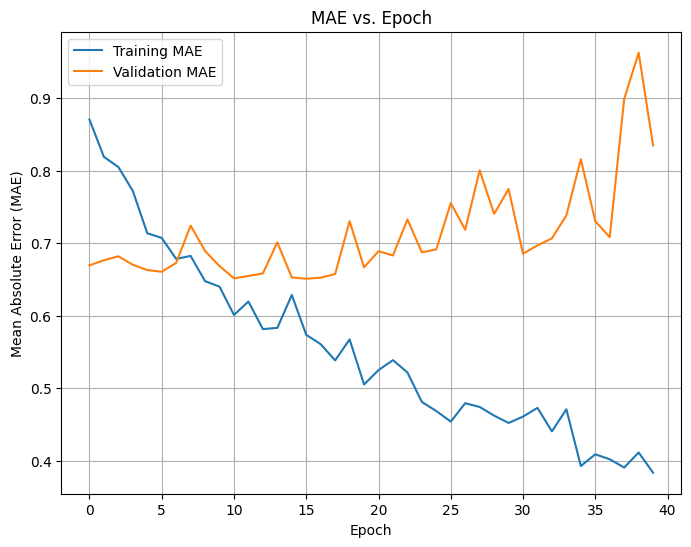

Test Loss: 1.3491753339767456
Test MAE:  0.944368302822113
3/3 [==============================] - 0s 6ms/step
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Test R^2: 0.046879746499308816


In [7]:
# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model on the full training set (optionally combine train+val)
history = best_model.fit(
    X_train_cnn, y_train,
    epochs=40,
    validation_data=(X_val_cnn, y_val)
)

# Store the MAE values for each epoch
mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot MAE as a function of epoch
plt.figure(figsize=(8, 6))
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on the test set
test_loss, test_mae = best_model.evaluate(X_test_cnn, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test MAE: ", test_mae)

# compute r^2 on the test set
y_pred = best_model.predict(X_test_cnn)
r2 = np.corrcoef(y_test, y_pred[:,0])[0,1]**2
print("Test R^2:", r2)

## Define Model